In [141]:
%matplotlib inline 
import matplotlib.pylab as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import importlib
from sklearn.cluster import SpectralBiclustering
import drought_ibf_utility as ibf
importlib.reload(ibf)
plt.rcParams.update({'figure.max_open_warning': 0})

# Data Collection

Add text.

# Data Preprocessing

In [2]:
data = ibf.prepare_Uganda_data()

data[244:254]

year  District Season       EVI      NDVI  SPEI_3month  \
244  2001      ABIM  11_12 -0.087761 -0.109488     1.014671   
245  2001      ABIM    6_7  0.176144  0.000840     0.159914   
246  2001  ADJUMANI  11_12 -0.119269 -0.513605    -0.190919   
247  2001  ADJUMANI    6_7 -1.100633 -0.769325     0.332131   
248  2001     AGAGO  11_12 -0.348043 -0.306330     0.785683   
249  2001     AGAGO    6_7  0.819081  0.449319     0.090941   
250  2001  ALEBTONG  11_12 -0.448223  0.214476     1.431628   
251  2001  ALEBTONG    6_7  0.114080  0.070315     0.381353   
252  2001  AMOLATAR  11_12  0.150026 -0.012156     0.080643   
253  2001  AMOLATAR    6_7 -0.316834 -0.012780     1.427053   

     SoilMoisture00_10cm  SoilMoisture100_200cm  SoilMoisture10_40cm  \
244             0.493821               0.183495             0.532963   
245             0.337568              -0.321696             0.178436   
246            -0.035800              -0.161188            -0.029763   
247             0.196787              -0.562899            -0.393729   
248             0.384324               0.133650             0.363145   
249             0.484683               0.068920             0.190540   
250             0.069056              -0.696214             0.097907   
251             0.508251              -1.005798             0.290490   
252             0.624266               0.348201             0.688907   
253             0.770144              -0.684640             0.532933   

     SoilMoisture40_100cm  ...  SoilTemperature40_100cm  air_temperature  \
244              0.545170  ...                -0.517657        -0.304553   
245              0.079531  ...                 0.071157         0.579569   
246             -0.063998  ...                -0.424694        -0.727866   
247             -0.656093  ...                 0.325616         0.317138   
248              0.379299  ...                -0.539449        -0.455596   
249              0.138024  ...                 0.123519         0.719499   
250              0.041647  ...                -0.418831        -0.493657   
251             -0.169471  ...                 0.003144         0.566832   
252              0.768526  ...                -0.787124        -0.600011   
253              0.134432  ...                -0.225300         0.043427   

     evapotranspiration  precipitation_per_hour_v1  precipitation_per_hour_v2  \
244            0.244027                   0.929294                  -0.254581   
245            1.411244                   1.397528                   0.528161   
246           -0.798907                  -1.046109                  -1.451136   
247            0.817708                  -0.172741                  -0.394678   
248           -0.140299                   0.084176                  -0.197233   
249            1.712607                   1.158751                   0.296855   
250           -0.210698                   0.678038                   0.497833   
251            1.682662                   1.523942                   0.828135   
252            0.483442                   0.290439                  -1.310691   
253            1.496043                   2.069834                   0.600145   

     rainfall  surface_temperature_daytime  surface_temperature_nighttime  \
244  0.823853                    -0.334808                      -0.132387   
245  0.546848                     0.105517                      -0.629675   
246 -0.588187                     0.817745                      -0.657459   
247  0.565755                     1.034436                       0.602927   
248  0.337310                    -0.057694                      -0.406609   
249  0.678685                    -0.202495                      -1.202925   
250  0.941653                     0.394610                      -0.432991   
251  0.879649                    -0.187035                      -1.336565   
252  0.421875                    -1.089499                      -1.457296   
253  1.765635      

In [60]:
id_cols = ['year','District','Season']
label_name = 'drought_reported'
All_features = list(data.drop(labels=id_cols+[label_name],axis=1).columns)
selected_features = All_features

# Data Exploration

In [4]:
reduced_data = ibf.reduce_data(data,label_name)

## Correlations among the features

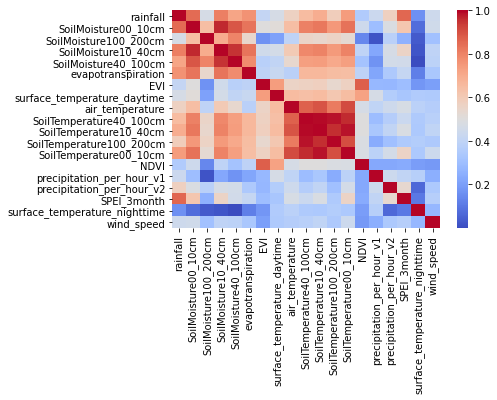

In [5]:
features = reduced_data[All_features].copy()
feature_corr = features.corr().abs()

bicluster_model = SpectralBiclustering(n_clusters=3, method='log',
                             random_state=0)
bicluster_model.fit(feature_corr)
feature_corr_sorted = feature_corr.values[np.argsort(bicluster_model.row_labels_),:]
feature_corr_sorted = feature_corr_sorted[:, np.argsort(bicluster_model.column_labels_)]
rows = feature_corr.columns[np.argsort(bicluster_model.row_labels_)]
cols = feature_corr.columns[np.argsort(bicluster_model.column_labels_)]
feature_corr_sorted = pd.DataFrame(feature_corr_sorted,index=rows,columns=cols)
sns.heatmap(feature_corr_sorted,cmap='coolwarm');

## Correlation with the target

In [6]:
median_vals = reduced_data[All_features+[label_name]].groupby(label_name).median().T.reset_index()
median_vals.rename(columns={True:'yes_drought', 
                            False:'no_drought', 
                            'Is_drought':'index',
                           'index':'feature'}, inplace= True)
median_vals['difference'] = (median_vals['yes_drought']-median_vals['no_drought']).abs()
median_vals.sort_values('difference',ascending=False,inplace=True)
median_vals.reset_index(inplace=True,drop=True)
median_vals.columns.name = None 
median_vals

feature  no_drought  yes_drought  difference
0             SoilMoisture00_10cm    0.280299    -0.570226    0.850525
1       precipitation_per_hour_v2    0.063213    -0.698218    0.761430
2             SoilMoisture10_40cm    0.216020    -0.530722    0.746742
3            SoilMoisture40_100cm    0.203412    -0.531513    0.734925
4              evapotranspiration    0.044880    -0.602795    0.647675
5                        rainfall    0.158049    -0.486975    0.645024
6        SoilTemperature100_200cm   -0.268359     0.320006    0.588365
7         SoilTemperature40_100cm   -0.224721     0.361192    0.585913
8          SoilTemperature10_40cm   -0.211171     0.302455    0.513625
9          SoilTemperature00_10cm   -0.144578     0.340174    0.484752
10                            EVI    0.214773    -0.196214    0.410986
11                    SPEI_3month    0.211545    -0.192696    0.404242
12                     wind_speed   -0.024963     0.329311    0.354275
13      precipitation_per_hour_v1   -0.240641    -0.549282    0.308641
14                           NDVI    0.141345    -0.127157    0.268502
15          SoilMoisture100_200cm   -0.036950    -0.292951    0.256001
16    surface_temperature_daytime   -0.092329     0.155518    0.247847
17                air_temperature   -0.153588     0.028358    0.181946
18  surface_temperature_nighttime    0.090008     0.235946    0.145938

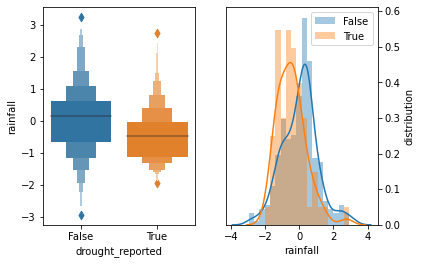

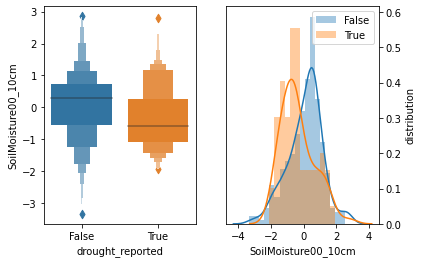

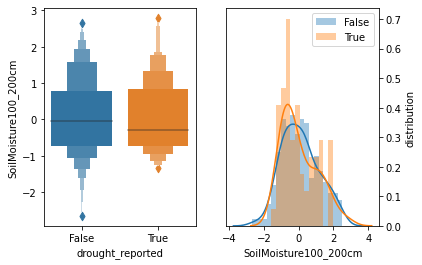

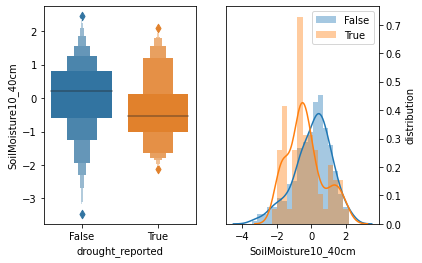

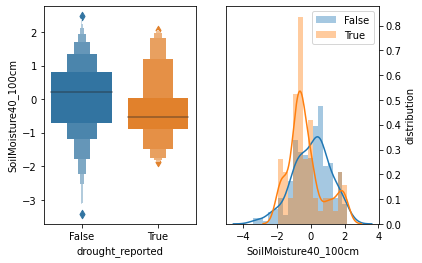

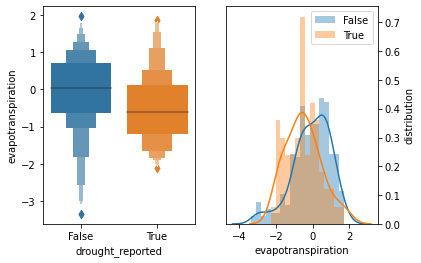

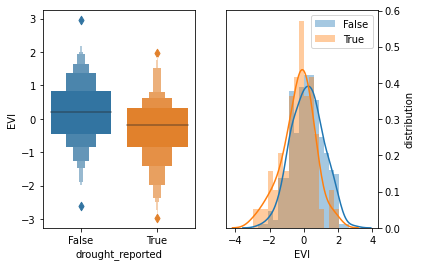

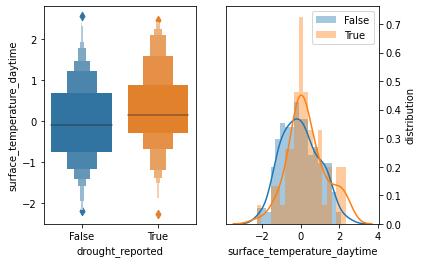

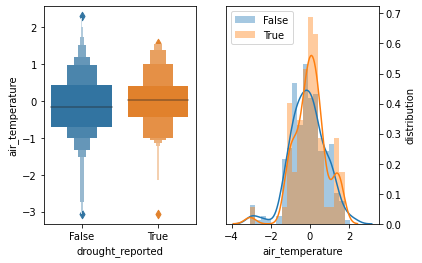

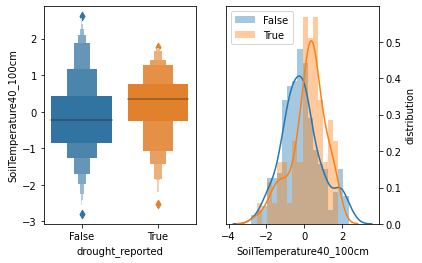

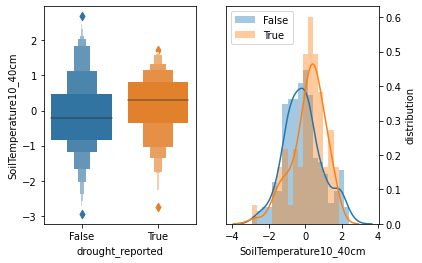

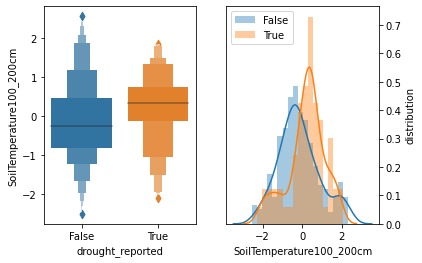

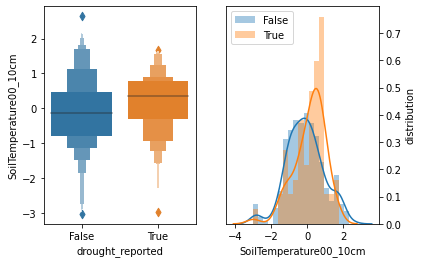

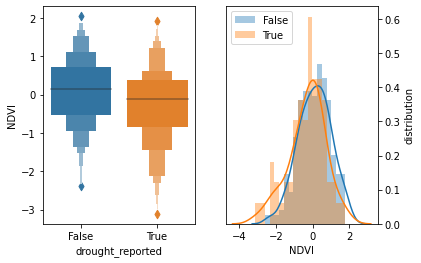

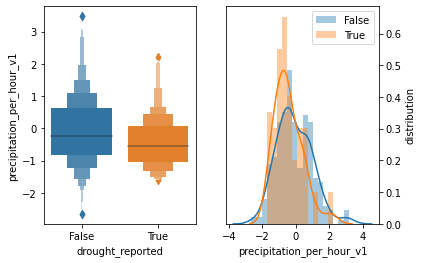

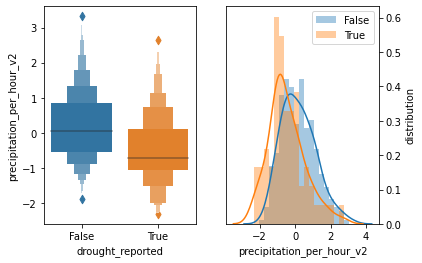

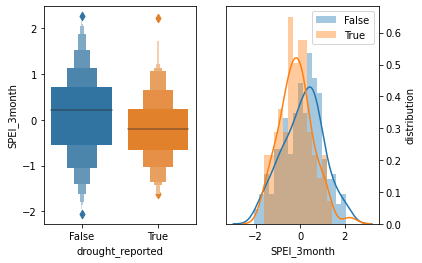

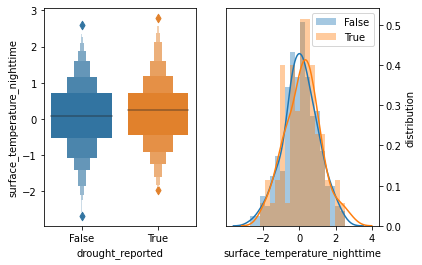

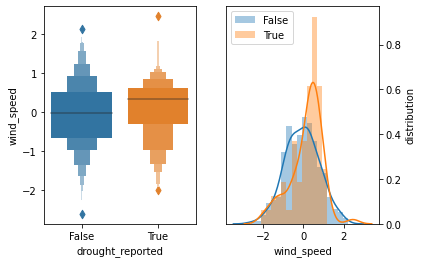

In [7]:
targets = feature_corr_sorted.columns

for target in targets:
    ibf.plot_dist(reduced_data,target,label_name)

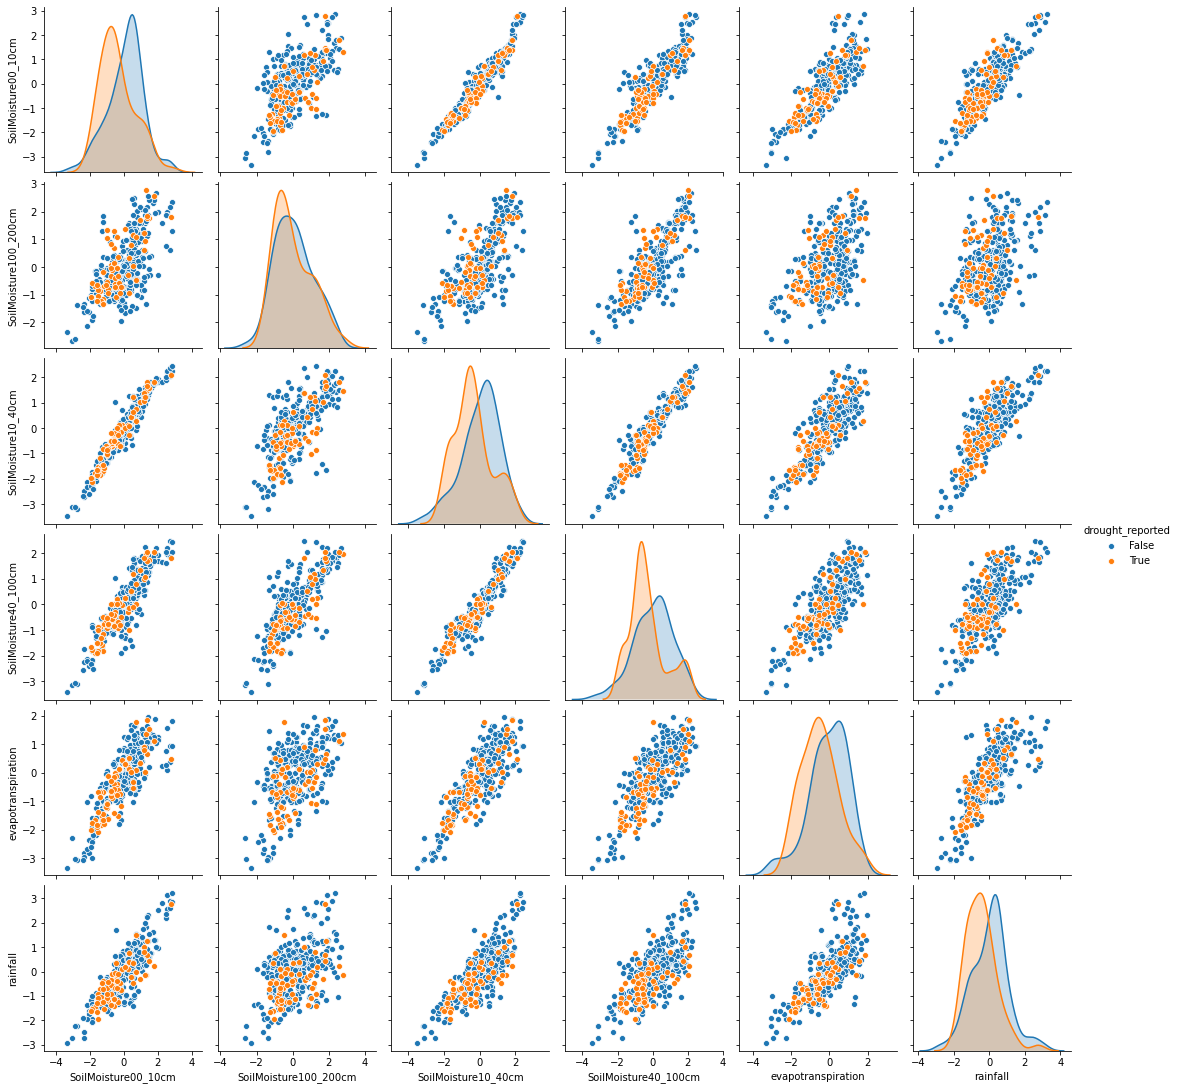

In [8]:
gruop_0 = feature_corr.columns[bicluster_model.row_labels_==0]
sns.pairplot(reduced_data, vars=gruop_0, hue=label_name);

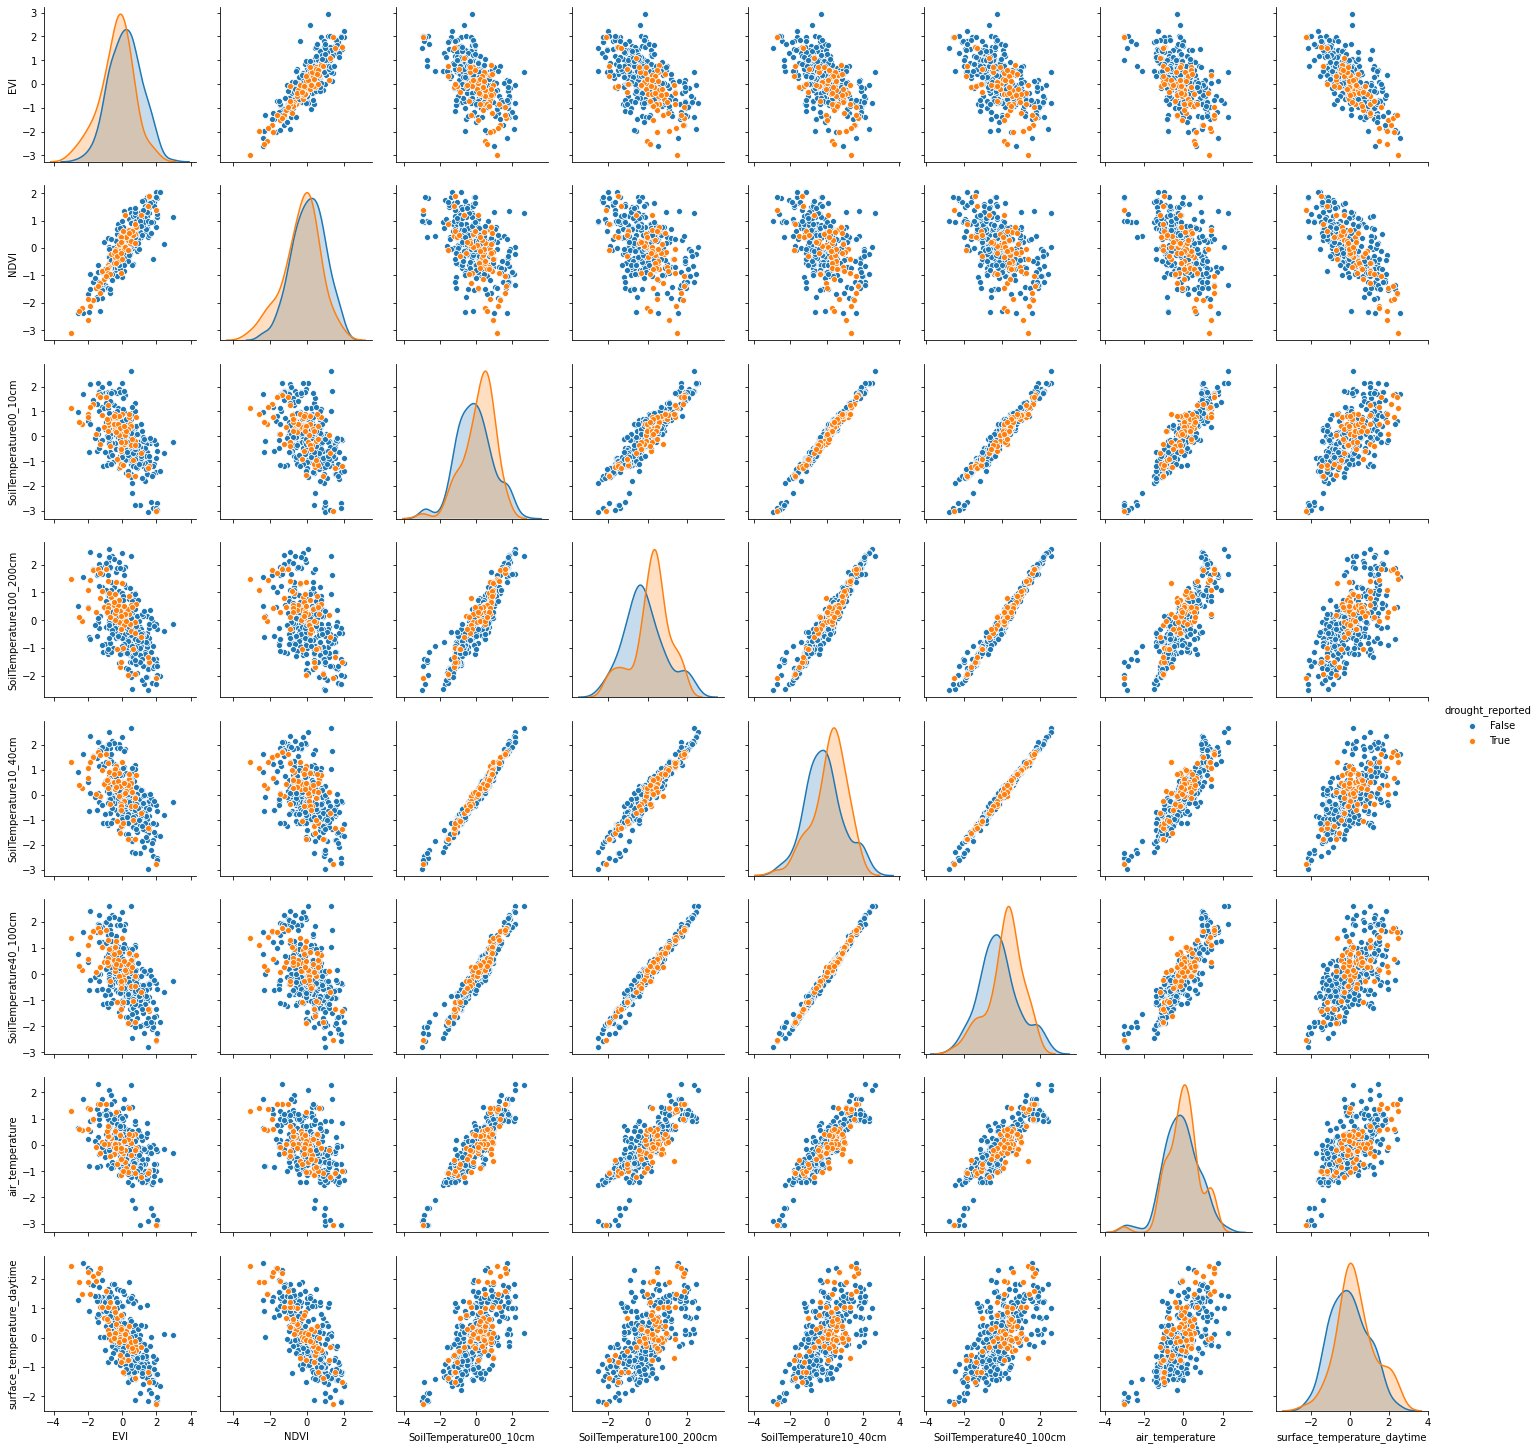

In [9]:
gruop_1 = feature_corr.columns[bicluster_model.row_labels_==1]
sns.pairplot(reduced_data, vars=gruop_1, hue=label_name);

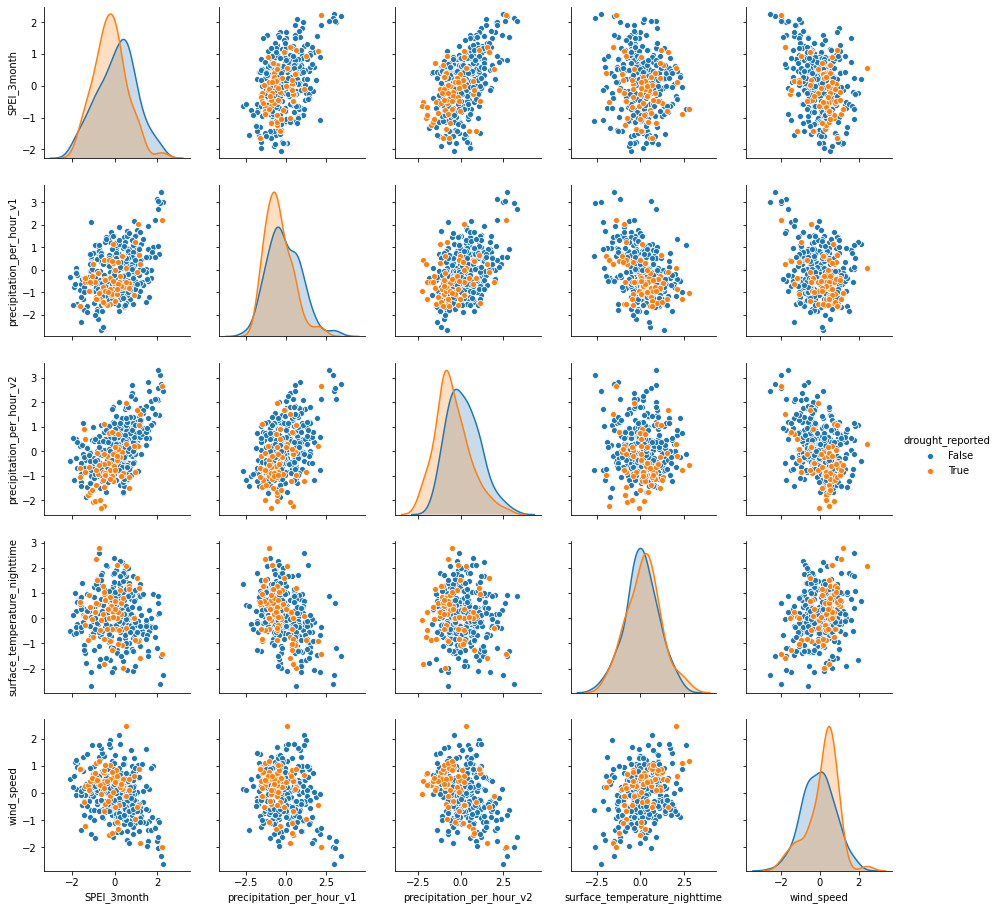

In [10]:
gruop_2 = feature_corr.columns[bicluster_model.row_labels_==2]
sns.pairplot(reduced_data, vars=gruop_2, hue=label_name);

# Fitting and Optimizing a Logistic Regression Model

In [11]:
np.random.seed(seed=10)

seeds = np.random.randint(1, 100, size=10)

C_array = np.concatenate((np.linspace(0.06,1,100),np.linspace(1,300,100)))

cv_scores = pd.DataFrame()

cv_scores['C'] = C_array

count = 0

for seed in seeds:
    
    count = count+1
    
    X,y,opt_model,mean_test_scores,std_test_scores =ibf.fit_Logreg_model(data, 
                                      selected_features, 
                                      label_name, 
                                      C_array,
                                      n_splits=3, 
                                      shuffle = True, 
                                      shuffle_seed=seed)
    
    cv_scores['shuffle_'+str(count)] = mean_test_scores
    
cv_scores.set_index('C',inplace=True)

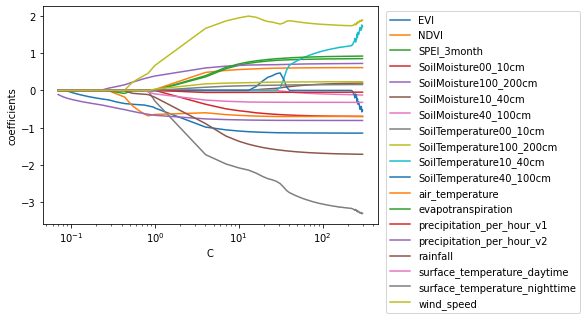

In [12]:
All_coefs = pd.DataFrame()

All_coefs['feature'] = selected_features

C_array = np.concatenate((np.linspace(0.07,1,100),np.linspace(1,300,100)))

fs = []

for C in C_array:
    opt_model.C = C
    opt_model.fit(X,y)
    y_pred = opt_model.predict(X)
    f = ibf.weighted_fscore(y, y_pred)
    fs.append(f)
    All_coefs[C] = opt_model.coef_.ravel()
    
All_coefs = All_coefs.set_index('feature').T.reset_index()
All_coefs.rename(columns={'index':'C'},inplace=True)

to_drop = (All_coefs.std()[All_coefs.std()==0].index)
All_coefs.drop(labels=to_drop,axis=1).plot(logx=True,x='C');
plt.legend(bbox_to_anchor=(1.01, 1));
plt.ylabel('coefficients');

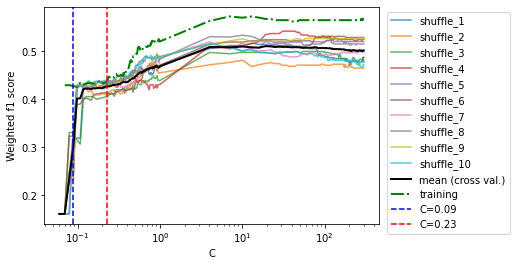

In [13]:
number_nonzero_coefs = All_coefs.set_index('C').astype(bool).sum(axis=1)
points = []
for n in range(1,number_nonzero_coefs.max()):
    point = number_nonzero_coefs[number_nonzero_coefs>n].index[0]
    points.append(point)

cv_scores.plot(logx=True,alpha=0.75)
ax=plt.gca()
cv_scores.mean(axis=1).plot(logx=True,color='k',lw=2,
                            label='mean (cross val.)',ax=ax)
ax=plt.gca()
ax.semilogx(C_array,fs,'-.',color='g',lw=2,label='training')

plt.axvline(x=points[0],color='b',ls='--',
            label='C='+str(round(points[0],2)))
plt.axvline(x=points[1],color='r',ls='--',
           label='C='+str(round(points[1],2)))

plt.ylabel('Weighted f1 score');
plt.legend()
plt.legend(bbox_to_anchor=(1.01, 1));

For values of C>24, the average cross-validation score only midly increase from 0.42 and quickly saturates at 0.48.

Example: overfitting

In [113]:
overfit_coefs,_,_,_,_ = ibf.predict_Logreg_model(opt_model, X, y, C=0.3, 
                                              confusion_matrix=False)
overfit_coefs.set_index('feature')

coef
feature                            
precipitation_per_hour_v2 -0.446389
EVI                       -0.274379
SoilMoisture100_200cm      0.074847
air_temperature           -0.035839
evapotranspiration        -0.023259

# Model Evaluation

In [45]:
C=0.225

coefs, predictions, pr, roc, auc = ibf.predict_Logreg_model(opt_model, 
                                                            X, y, C=C, 
                                                            confusion_matrix=True)

                 Confusion matrix
                 Score positive    Score negative
Actual positive        45                20
Actual negative       127               170

Accuracy  0.59
 
           Positive      Negative
Num case       65           297
Precision    0.26          0.89
Recall       0.69          0.57
F-score      0.38          0.70


Weighted Average F-score  0.44


Random Model:

In [142]:
_,_= ibf.fit_random_model(y)

           Positive      Negative
Precision    0.18          0.82
Recall       0.50          0.50
F_score      0.26          0.62


Nonzero coefficients:

In [112]:
coefs.set_index('feature')

coef
feature                            
precipitation_per_hour_v2 -0.384328
EVI                       -0.225052

Distributions of the model scores:

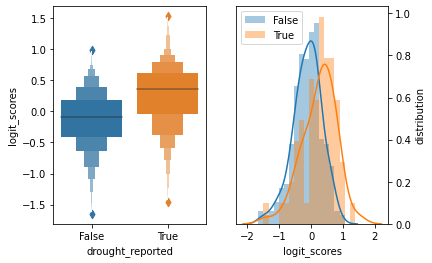

In [47]:
ibf.plot_dist(predictions, 'logit_scores', label_name)

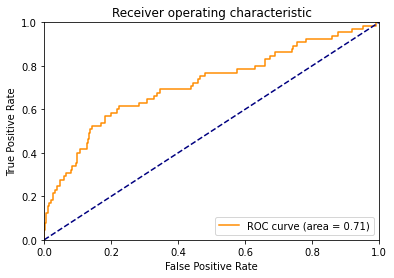

In [48]:
plt.plot(roc[0],roc[1],color='darkorange',
         label='ROC curve (area = %0.2f)' % auc)
plt.plot([0,1],[0,1],'--',color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic');

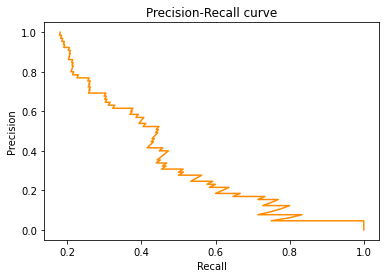

In [49]:
plt.plot(pr[0],pr[1],color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision');
plt.title('Precision-Recall curve');

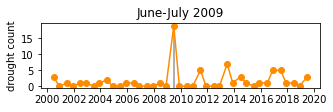

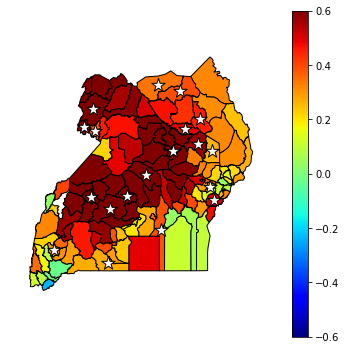

In [50]:
year = 2009
season = '6_7'
ibf.visualize_droughts_uganda(data,opt_model,year,season,selected_features,
                             label_name)

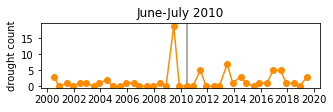

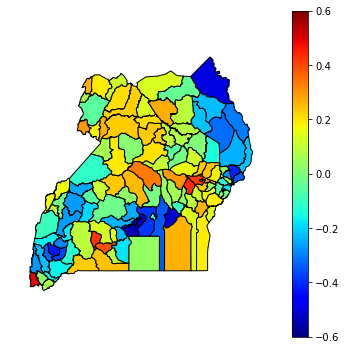

In [51]:
year = 2010
season = '6_7'
ibf.visualize_droughts_uganda(data,opt_model,year,season,selected_features,
                             label_name)

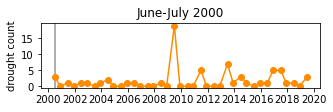

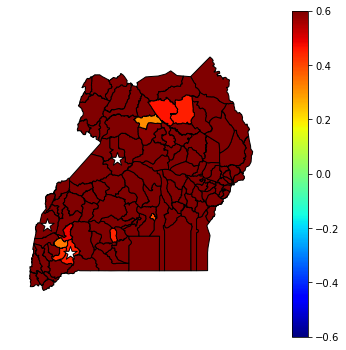

In [70]:
year = 2000
season = '6_7'
ibf.visualize_droughts_uganda(data,opt_model,year,season,selected_features,
                             label_name)

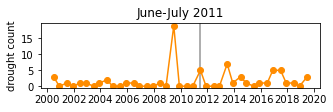

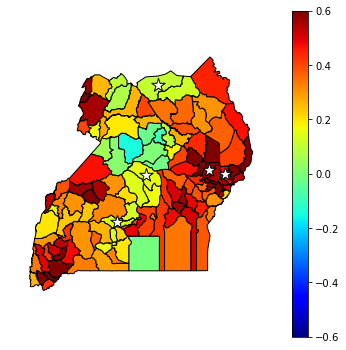

In [64]:
year = 2011
season = '6_7'
ibf.visualize_droughts_uganda(data,opt_model,year,season,selected_features,
                             label_name)

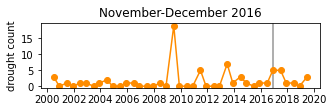

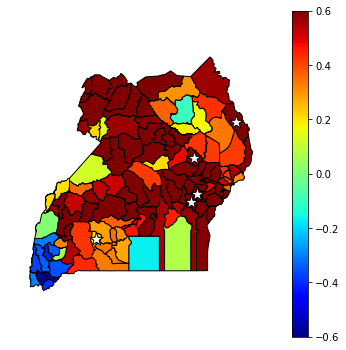

In [63]:
year = 2016
season = '11_12'
ibf.visualize_droughts_uganda(data,opt_model,year,season,selected_features,
                             label_name)


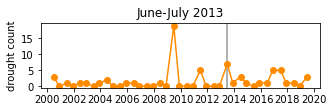

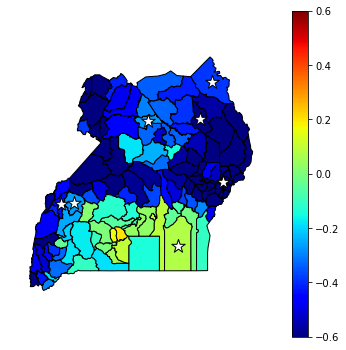

In [54]:
year = 2013
season = '6_7'
ibf.visualize_droughts_uganda(data,opt_model,year,season,selected_features,
                             label_name)

# Anomaly in 2013

In [68]:
data_nolag = ibf.prepare_Uganda_data(first_planting = [5,6,7],
                       second_planting = [10,11,12])

selected_features_nolag = list(data_nolag.drop(labels=id_cols+[label_name],axis=1).columns)

data_nolag.head()

year  District Season       EVI      NDVI  SPEI_3month  \
0  2000      ABIM  11_12  0.345340  0.273155    -0.380940   
1  2000      ABIM    6_7 -0.610216 -0.972721     1.070958   
2  2000  ADJUMANI  11_12 -2.509297 -2.681439    -0.785817   
3  2000  ADJUMANI    6_7 -1.922668 -2.033553    -1.273670   
4  2000     AGAGO  11_12  0.173825 -0.172256    -0.813994   

   SoilMoisture00_10cm  SoilMoisture100_200cm  SoilMoisture10_40cm  \
0             0.480062               0.265886             0.641735   
1             0.221030              -0.538067             0.105273   
2            -0.786316              -0.628256            -0.752644   
3            -0.699665              -0.319296            -0.654536   
4             0.273419               0.562801             0.611708   

   SoilMoisture40_100cm  ...  SoilTemperature40_100cm  air_temperature  \
0              0.648014  ...                -0.341013         0.467706   
1             -0.182383  ...                 0.731467         0.599766   
2             -0.757014  ...                 0.356752         0.182994   
3             -0.587120  ...                 1.167563         0.898343   
4              0.608860  ...                -0.269910         0.428155   

   evapotranspiration  precipitation_per_hour_v1  precipitation_per_hour_v2  \
0            0.919767                   0.275953                  -0.777004   
1            0.516025                   0.341420                  -0.056483   
2           -1.230370                  -0.632146                  -2.078888   
3            0.143570                  -0.485364                  -1.829607   
4            0.631139                   0.204470                  -0.017153   

   rainfall  surface_temperature_daytime  surface_temperature_nighttime  \
0  0.345946                    -0.816773                      -0.974595   
1  1.043193                     1.418636                      -0.211015   
2 -1.315605                     1.808219                      -0.988551   
3 -0.991914                     2.237074                      -1.282920   
4 -0.011947                    -0.924669                      -2.160256   

   wind_speed  drought_reported  
0   -0.502222             False  
1   -0.351531             False  
2   -0.597454             False  
3    0.689930             False  
4   -0.484522             False  

[5 rows x 23 columns]

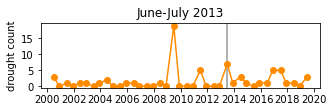

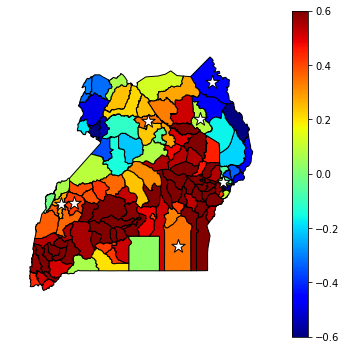

In [69]:
year = 2013
season = '6_7'

ibf.visualize_droughts_uganda(data_nolag,opt_model,year,season,
                              selected_features=selected_features_nolag,
                             label_name=label_name)

# Appendix: Global Drought Prediction

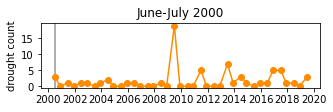

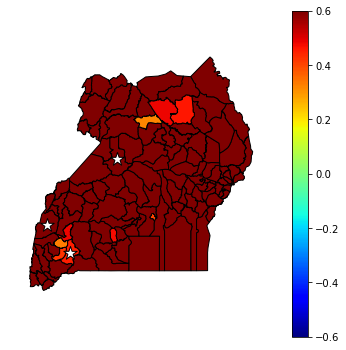

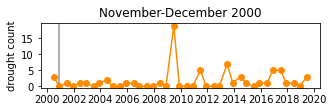

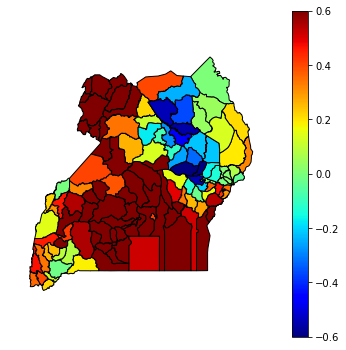

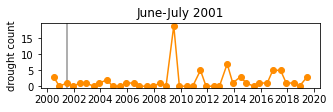

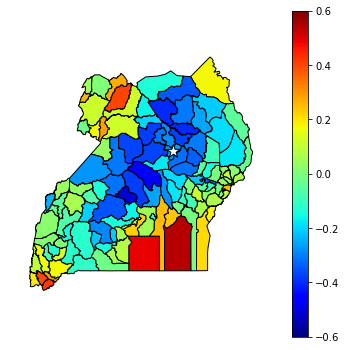

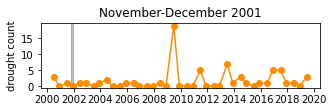

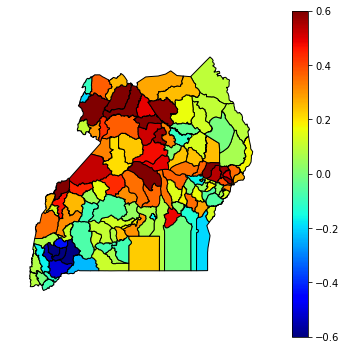

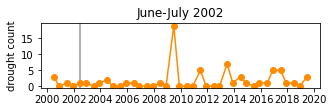

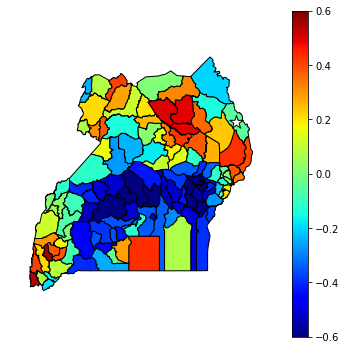

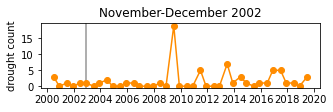

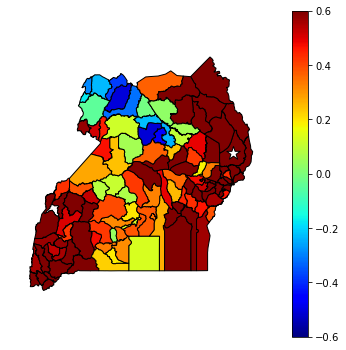

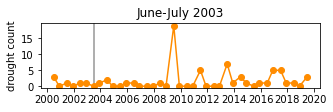

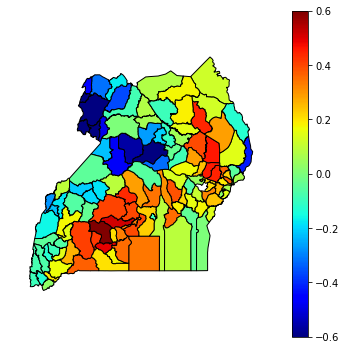

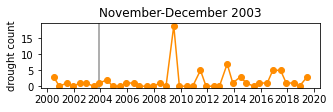

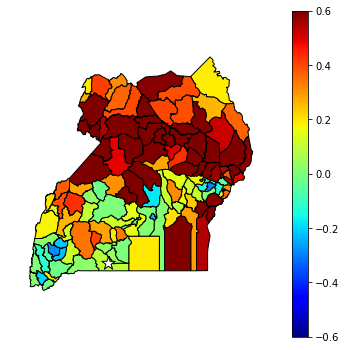

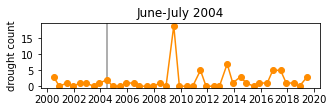

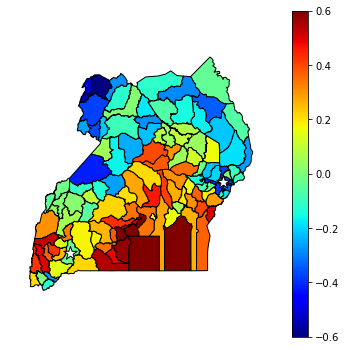

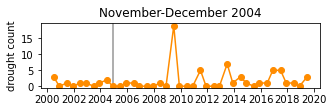

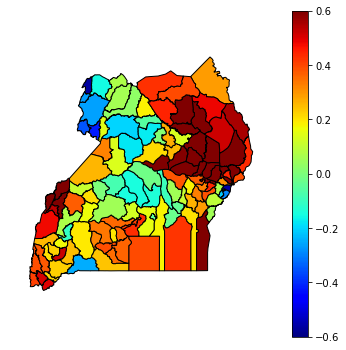

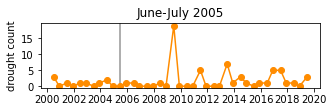

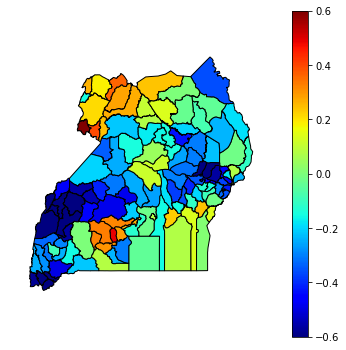

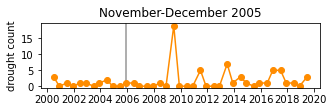

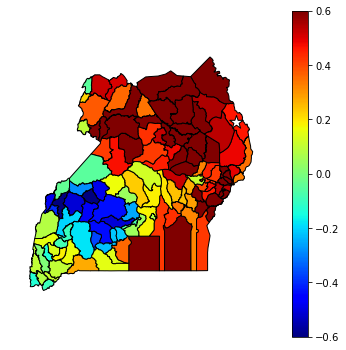

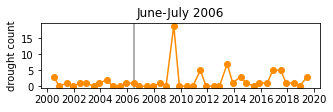

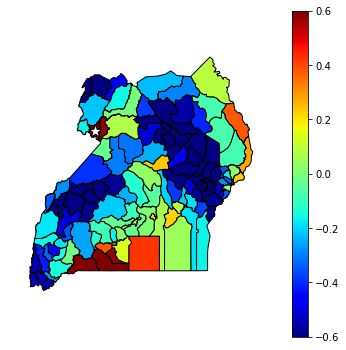

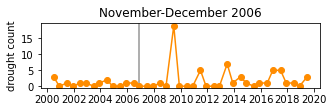

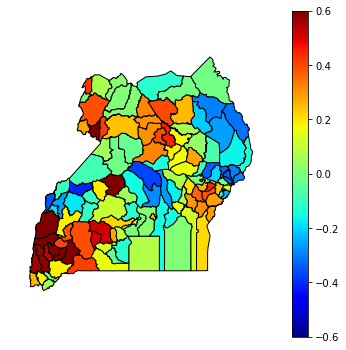

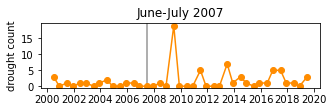

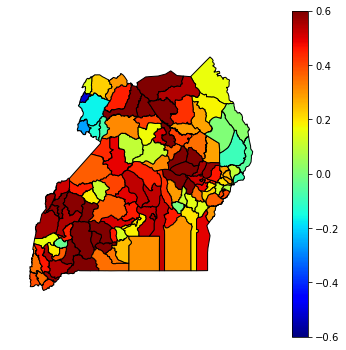

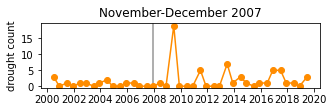

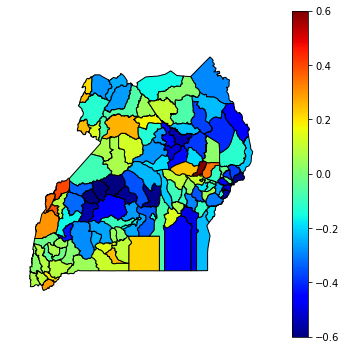

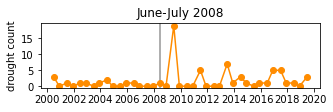

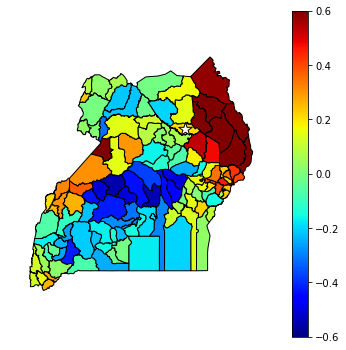

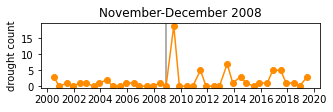

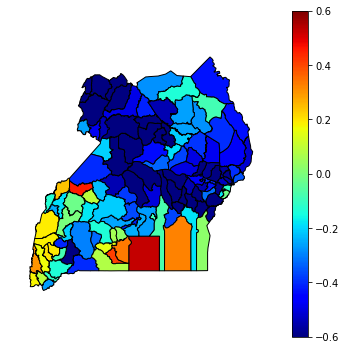

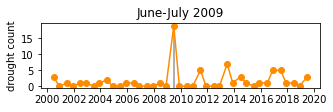

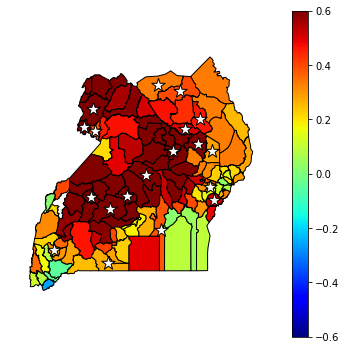

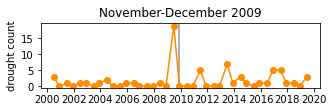

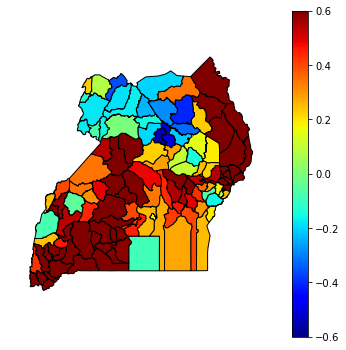

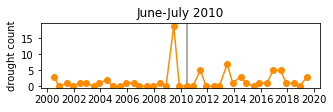

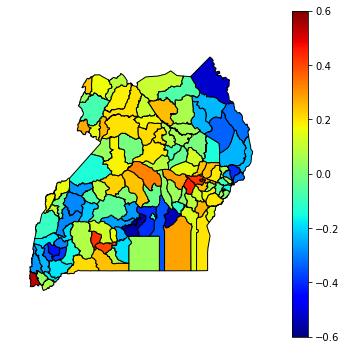

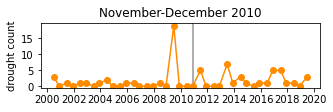

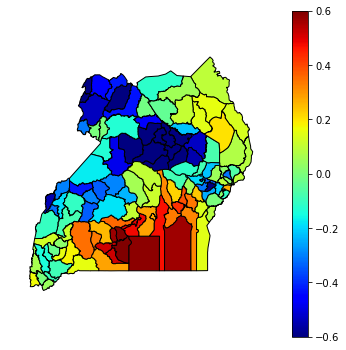

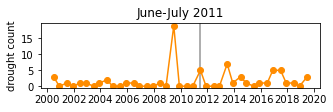

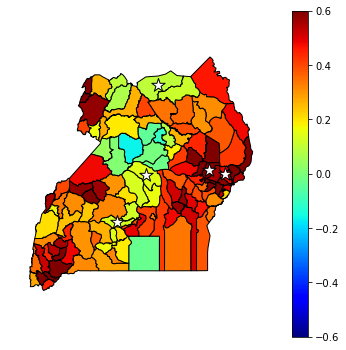

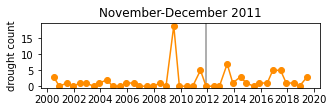

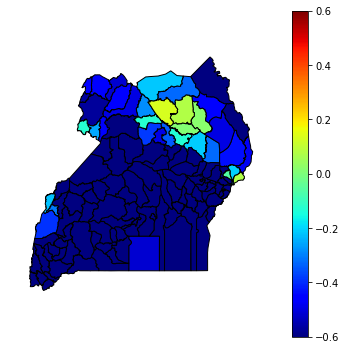

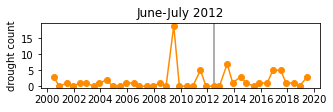

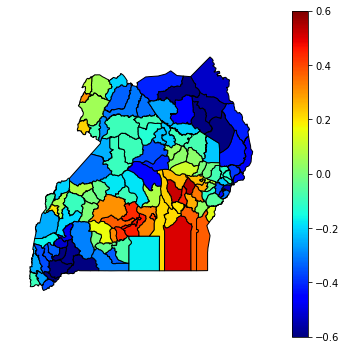

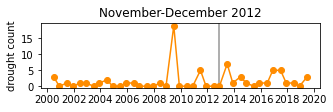

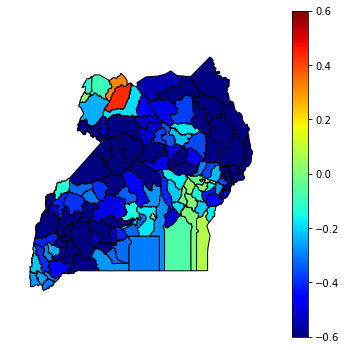

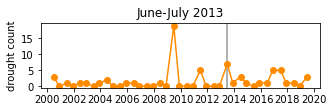

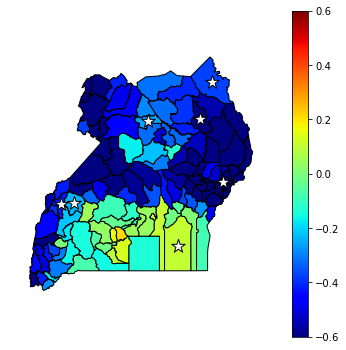

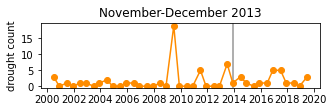

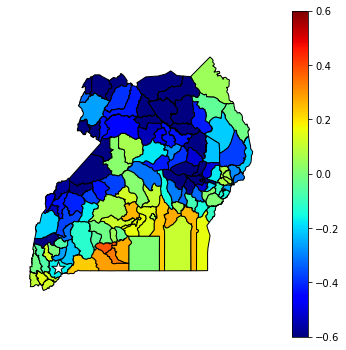

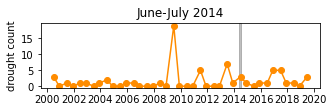

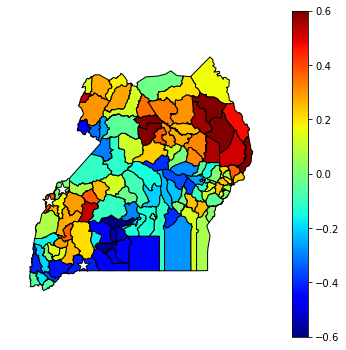

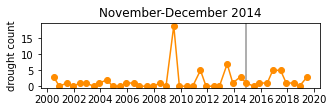

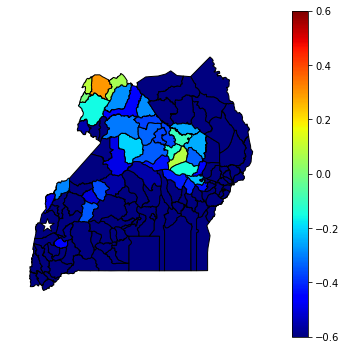

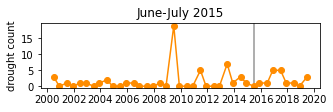

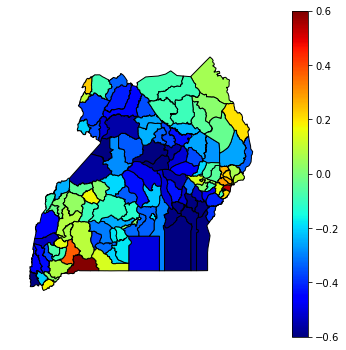

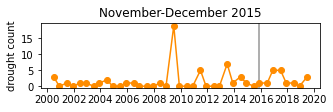

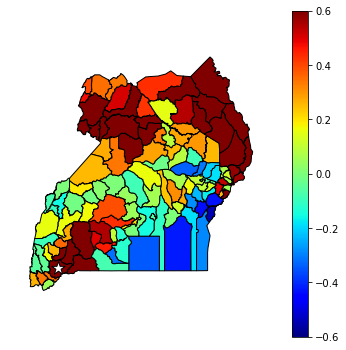

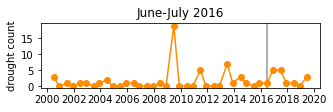

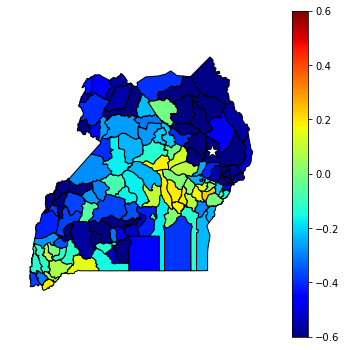

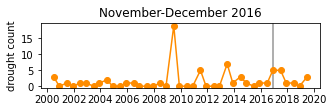

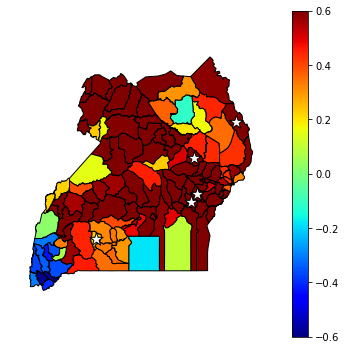

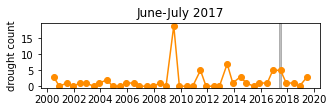

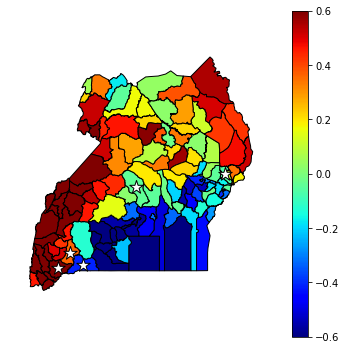

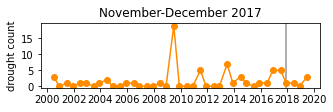

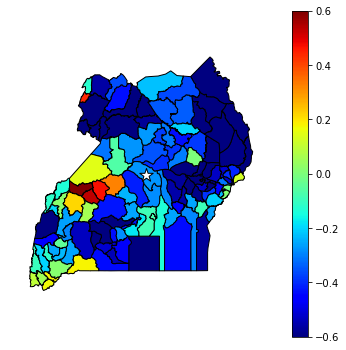

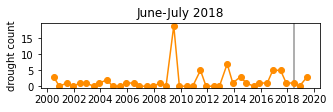

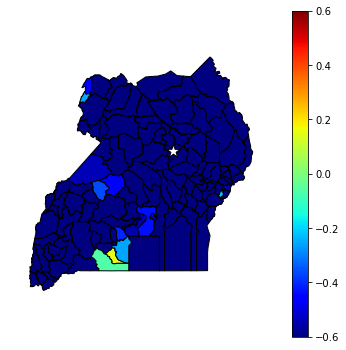

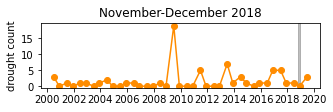

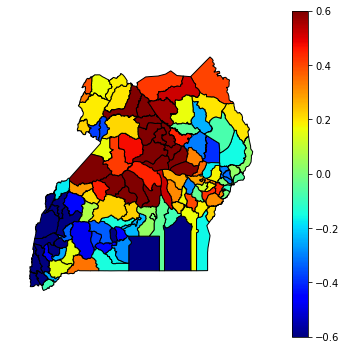

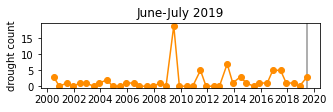

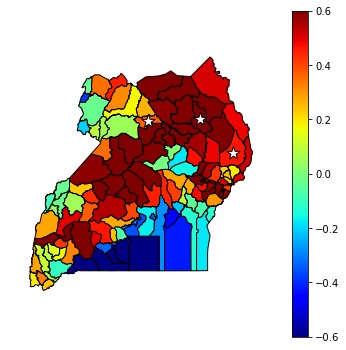

In [25]:
years = data.year.unique()
for year in years:
    seasons = np.flip(data[data.year==year]['Season'].unique())
    for season in seasons:
        ibf.visualize_droughts_uganda(data,opt_model,year,season,selected_features,
                             label_name)
        